In [1]:
%load_ext autoreload 
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt

from loader import All_fundus_files
from networks import weights_init, Discriminator_128_v2_PatchGAN, Flatten, Discriminator_128_v2_DC_PatchGAN_CLS

dataroot = "data/fundus2/"
batch_size = 64
image_size = 128 #size using data aug.
num_classes = 5

ch_out = 3 
#ch_noise = 100
#ch_g = 64
ch_d = 64

num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    cudnn.benchmark = True

cuda


In [2]:
# Data
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.ImageFolder(root=dataroot+'sorted', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

testset = torchvision.datasets.ImageFolder(root=dataroot+'val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

classes = testset.classes
print(trainset.classes)
print(testset.class_to_idx)
print(len(trainset), len(testset))

['catergory00', 'catergory01', 'catergory02', 'catergory03', 'catergory04']
{'catergory00': 0, 'catergory01': 1, 'catergory02': 2, 'catergory03': 3, 'catergory04': 4}
3462 200


In [3]:
# Model
net = Discriminator_128_v2_DC_PatchGAN_CLS(ch_out, ch_d, num_classes)
net = net.to(device)
net.apply(weights_init)
print(net)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if False:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/exp8/ckpt.pth')
    msg = net.load_state_dict(checkpoint['net'], strict=False)
    assert set(msg.missing_keys) == {'fc.weight', 'fc.bias'}, 'missing_keys: {}'.format(set(msg.missing_keys))
    #assert set(msg.unexpected_keys) == {"backbone.14.weight"}, 'unexpected_keys: {}'.format(set(msg.unexpected_keys))
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(best_acc,start_epoch)
    
    for name, param in net.named_parameters():
        if name not in ["brunch1.0.weight", "fc.weight", "fc.bias"]:
            param.requires_grad = False
        else:
            print('{}'.format(name))
    '''
    backbone.0.weight
    backbone.2.weight
    backbone.5.weight
    backbone.8.weight
    brunch1.0.weight
    out1.0.weight
    brunch2.0.weight
    out2.0.weight
    fc.weight
    fc.bias
    '''
    # check
    parameters = list(filter(lambda p: p.requires_grad, net.parameters()))
    assert len(parameters) == 3
else:
    parameters = net.parameters()


# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=lr, betas=(beta1, 0.999))
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100,250], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Discriminator_128_v2_DC_PatchGAN_CLS(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (brunch1): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2,

In [5]:
from torchsummary import summary
summary(net, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 4, 4]               0
        LeakyReLU-14           [-1, 102

In [4]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' %(train_loss / (batch_idx+1), 100.*correct/total, correct, total))
    return train_loss /(batch_idx+1), correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' %(test_loss /(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss /(batch_idx+1), correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint/exp3'):
            os.mkdir('checkpoint/exp3')
        torch.save(state, './checkpoint/exp3/ckpt.pth')
        best_acc = acc

Train_losses = []
Test_losses = []
Train_acc = []
Test_acc = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    ls, acc = train(epoch)
    Train_losses.append(ls)
    Train_acc.append(acc)
    
    ls, acc = test(epoch)
    Test_losses.append(ls)
    Test_acc.append(acc)
    
    scheduler.step()


Epoch: 0
Train Loss: 0.978 | Acc: 66.551% (2304/3462)
Test Loss: 1.798 | Acc: 41.000% (82/200)

Epoch: 1
Train Loss: 0.817 | Acc: 71.519% (2476/3462)
Test Loss: 1.628 | Acc: 36.000% (72/200)

Epoch: 2
Train Loss: 0.792 | Acc: 72.270% (2502/3462)
Test Loss: 1.616 | Acc: 37.000% (74/200)

Epoch: 3
Train Loss: 0.765 | Acc: 73.195% (2534/3462)
Test Loss: 1.949 | Acc: 34.500% (69/200)

Epoch: 4
Train Loss: 0.755 | Acc: 73.195% (2534/3462)
Test Loss: 1.604 | Acc: 45.000% (90/200)

Epoch: 5
Train Loss: 0.732 | Acc: 73.484% (2544/3462)
Test Loss: 1.688 | Acc: 42.000% (84/200)

Epoch: 6
Train Loss: 0.732 | Acc: 74.292% (2572/3462)
Test Loss: 1.669 | Acc: 39.500% (79/200)

Epoch: 7
Train Loss: 0.718 | Acc: 73.715% (2552/3462)
Test Loss: 1.511 | Acc: 50.000% (100/200)

Epoch: 8
Train Loss: 0.699 | Acc: 74.552% (2581/3462)
Test Loss: 1.500 | Acc: 44.500% (89/200)

Epoch: 9
Train Loss: 0.700 | Acc: 74.870% (2592/3462)
Test Loss: 1.480 | Acc: 45.000% (90/200)

Epoch: 10
Train Loss: 0.701 | Acc: 74.

Train Loss: 0.124 | Acc: 98.065% (3395/3462)
Test Loss: 1.052 | Acc: 51.500% (103/200)

Epoch: 85
Train Loss: 0.135 | Acc: 97.574% (3378/3462)
Test Loss: 1.513 | Acc: 55.000% (110/200)

Epoch: 86
Train Loss: 0.117 | Acc: 98.209% (3400/3462)
Test Loss: 1.476 | Acc: 56.500% (113/200)

Epoch: 87
Train Loss: 0.114 | Acc: 98.296% (3403/3462)
Test Loss: 1.592 | Acc: 54.500% (109/200)

Epoch: 88
Train Loss: 0.105 | Acc: 98.325% (3404/3462)
Test Loss: 1.404 | Acc: 55.500% (111/200)

Epoch: 89
Train Loss: 0.104 | Acc: 98.527% (3411/3462)
Test Loss: 1.217 | Acc: 57.500% (115/200)

Epoch: 90
Train Loss: 0.095 | Acc: 98.671% (3416/3462)
Test Loss: 1.762 | Acc: 55.500% (111/200)

Epoch: 91
Train Loss: 0.094 | Acc: 98.527% (3411/3462)
Test Loss: 1.545 | Acc: 55.000% (110/200)

Epoch: 92
Train Loss: 0.091 | Acc: 98.498% (3410/3462)
Test Loss: 1.232 | Acc: 57.000% (114/200)

Epoch: 93
Train Loss: 0.085 | Acc: 98.729% (3418/3462)
Test Loss: 1.645 | Acc: 54.000% (108/200)

Epoch: 94
Train Loss: 0.084 | 

Train Loss: 0.037 | Acc: 98.758% (3419/3462)
Test Loss: 1.447 | Acc: 55.000% (110/200)

Epoch: 168
Train Loss: 0.029 | Acc: 99.047% (3429/3462)
Test Loss: 2.089 | Acc: 56.000% (112/200)

Epoch: 169
Train Loss: 0.036 | Acc: 98.902% (3424/3462)
Test Loss: 1.784 | Acc: 59.000% (118/200)

Epoch: 170
Train Loss: 0.079 | Acc: 97.545% (3377/3462)
Test Loss: 2.009 | Acc: 46.000% (92/200)

Epoch: 171
Train Loss: 0.088 | Acc: 97.776% (3385/3462)
Test Loss: 1.956 | Acc: 55.000% (110/200)

Epoch: 172
Train Loss: 0.045 | Acc: 98.642% (3415/3462)
Test Loss: 1.735 | Acc: 57.500% (115/200)

Epoch: 173
Train Loss: 0.032 | Acc: 99.191% (3434/3462)
Test Loss: 1.724 | Acc: 57.500% (115/200)

Epoch: 174
Train Loss: 0.039 | Acc: 98.960% (3426/3462)
Test Loss: 2.614 | Acc: 52.500% (105/200)

Epoch: 175
Train Loss: 0.043 | Acc: 98.758% (3419/3462)
Test Loss: 1.787 | Acc: 55.500% (111/200)

Epoch: 176
Train Loss: 0.032 | Acc: 98.931% (3425/3462)
Test Loss: 1.426 | Acc: 55.500% (111/200)

Epoch: 177
Train Loss:

Train Loss: 0.024 | Acc: 99.076% (3430/3462)
Test Loss: 2.081 | Acc: 54.000% (108/200)

Epoch: 251
Train Loss: 0.019 | Acc: 99.133% (3432/3462)
Test Loss: 1.824 | Acc: 57.500% (115/200)

Epoch: 252
Train Loss: 0.023 | Acc: 99.105% (3431/3462)
Test Loss: 2.149 | Acc: 54.500% (109/200)

Epoch: 253
Train Loss: 0.022 | Acc: 99.105% (3431/3462)
Test Loss: 1.956 | Acc: 52.000% (104/200)

Epoch: 254
Train Loss: 0.024 | Acc: 98.873% (3423/3462)
Test Loss: 2.183 | Acc: 54.500% (109/200)

Epoch: 255
Train Loss: 0.023 | Acc: 99.018% (3428/3462)
Test Loss: 1.884 | Acc: 57.000% (114/200)

Epoch: 256
Train Loss: 0.022 | Acc: 98.873% (3423/3462)
Test Loss: 2.128 | Acc: 54.000% (108/200)

Epoch: 257
Train Loss: 0.029 | Acc: 98.787% (3420/3462)
Test Loss: 1.909 | Acc: 53.000% (106/200)

Epoch: 258
Train Loss: 0.025 | Acc: 99.018% (3428/3462)
Test Loss: 2.177 | Acc: 53.500% (107/200)

Epoch: 259
Train Loss: 0.023 | Acc: 98.902% (3424/3462)
Test Loss: 2.169 | Acc: 53.500% (107/200)

Epoch: 260
Train Loss

Train Loss: 0.016 | Acc: 99.220% (3435/3462)
Test Loss: 2.102 | Acc: 56.500% (113/200)

Epoch: 334
Train Loss: 0.018 | Acc: 98.960% (3426/3462)
Test Loss: 2.297 | Acc: 53.500% (107/200)

Epoch: 335
Train Loss: 0.018 | Acc: 98.989% (3427/3462)
Test Loss: 2.350 | Acc: 52.500% (105/200)

Epoch: 336
Train Loss: 0.017 | Acc: 99.018% (3428/3462)
Test Loss: 2.269 | Acc: 54.000% (108/200)

Epoch: 337
Train Loss: 0.015 | Acc: 99.191% (3434/3462)
Test Loss: 2.061 | Acc: 57.500% (115/200)

Epoch: 338
Train Loss: 0.020 | Acc: 98.787% (3420/3462)
Test Loss: 2.253 | Acc: 55.000% (110/200)

Epoch: 339
Train Loss: 0.017 | Acc: 98.902% (3424/3462)
Test Loss: 2.222 | Acc: 57.000% (114/200)

Epoch: 340
Train Loss: 0.017 | Acc: 98.960% (3426/3462)
Test Loss: 2.223 | Acc: 56.000% (112/200)

Epoch: 341
Train Loss: 0.017 | Acc: 99.047% (3429/3462)
Test Loss: 2.156 | Acc: 55.500% (111/200)

Epoch: 342
Train Loss: 0.016 | Acc: 99.076% (3430/3462)
Test Loss: 2.054 | Acc: 56.000% (112/200)

Epoch: 343
Train Loss

Train Loss: 0.012 | Acc: 99.365% (3440/3462)
Test Loss: 2.319 | Acc: 55.500% (111/200)

Epoch: 417
Train Loss: 0.014 | Acc: 99.105% (3431/3462)
Test Loss: 2.392 | Acc: 56.000% (112/200)

Epoch: 418
Train Loss: 0.014 | Acc: 99.076% (3430/3462)
Test Loss: 2.409 | Acc: 56.000% (112/200)

Epoch: 419
Train Loss: 0.013 | Acc: 99.191% (3434/3462)
Test Loss: 2.332 | Acc: 56.500% (113/200)

Epoch: 420
Train Loss: 0.013 | Acc: 99.249% (3436/3462)
Test Loss: 2.276 | Acc: 57.000% (114/200)

Epoch: 421
Train Loss: 0.014 | Acc: 99.191% (3434/3462)
Test Loss: 2.299 | Acc: 57.500% (115/200)

Epoch: 422
Train Loss: 0.014 | Acc: 99.047% (3429/3462)
Test Loss: 2.338 | Acc: 58.000% (116/200)

Epoch: 423
Train Loss: 0.013 | Acc: 99.249% (3436/3462)
Test Loss: 2.337 | Acc: 57.500% (115/200)

Epoch: 424
Train Loss: 0.014 | Acc: 99.018% (3428/3462)
Test Loss: 2.401 | Acc: 57.000% (114/200)

Epoch: 425
Train Loss: 0.013 | Acc: 99.220% (3435/3462)
Test Loss: 2.410 | Acc: 57.000% (114/200)

Epoch: 426
Train Loss

Train Loss: 0.012 | Acc: 99.220% (3435/3462)
Test Loss: 2.351 | Acc: 56.500% (113/200)


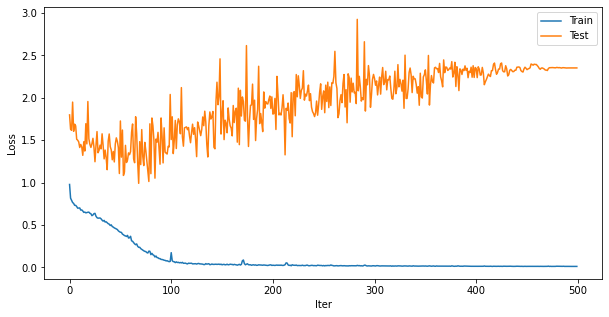

In [5]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(Train_losses,label="Train")
plt.plot(Test_losses,label="Test")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

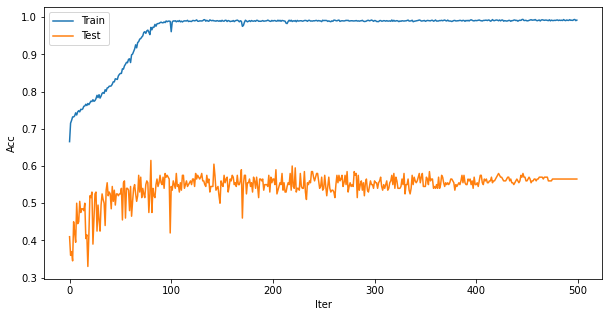

In [6]:
# check acc
plt.figure(figsize=(10,5))
plt.plot(Train_acc,label="Train")
plt.plot(Test_acc,label="Test")
plt.xlabel("Iter")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [7]:
def test_only():
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    return (100 * correct / total)

acc = test_only() 

Accuracy of the network on the 10000 test images: 56.500000 %


In [8]:
def test_each_class():
    net.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    #label = int(label.cpu().numpy())
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.2f} %".format(classname,
        accuracy))

test_each_class()

Accuracy for class catergory00 is: 97.50 %
Accuracy for class catergory01 is: 57.50 %
Accuracy for class catergory02 is: 85.00 %
Accuracy for class catergory03 is: 30.00 %
Accuracy for class catergory04 is: 12.50 %


In [ ]:
# save
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
#torch.save(state, './checkpoint/ckpt_fin.pth')

In [ ]:
# load
resume = 'ckpt'
checkpoint = torch.load('./checkpoint/'+resume+'.pth')
#net.load_state_dict(checkpoint['net'])

In [ ]:
acc = test_only() 
test_each_class()